# Optogenetics

#### **Basic instructions:**
#### 1. **To run code windows/blocks:** 

    - you can either hit the play button to the left of the code window 

    - or you can use they keyboard shortcut: select the block and press 'shift-enter'.

#### 2. The first time you run this code notebook, you will get a popup asking to choose which version of Python to use (the python "kernel"). **Choose the python kernel called "CSHL_IonChannels"**

    - If you did it correctly, you should see "CSHL_IonChannels (Python 3.11.13)" in the top right of the screen.

#### 3. Make sure you data (.abf) files are in the "data" folder here on the left. You can just copy/paste the files from where they are saved on your computer.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *
update_plot_defaults()
%load_ext autoreload
%autoreload 2

## 1. Choose the data file you want to analyze

#### Put the .abf files with your Ih recordings in the "data/Synaptic_currents" folder

In [2]:
data_folder = "data/9-Opto"

from glob import glob
data_files = glob(data_folder+"/*.abf")
data_files.sort()
print(data_folder)
data_files

data/9-Opto


['data/9-Opto/2024_06_18_0013.abf',
 'data/9-Opto/2024_06_18_0014.abf',
 'data/9-Opto/2024_06_18_0015.abf',
 'data/9-Opto/2024_06_18_0016.abf',
 'data/9-Opto/2024_06_18_0017.abf',
 'data/9-Opto/2024_06_18_0019.abf',
 'data/9-Opto/2024_06_18_0020.abf',
 'data/9-Opto/2024_06_18_0025.abf']

Choose which file you want to analyze (copy name from above) and paste the file name here:

In [3]:
data_file = 'data/9-Opto/2024_06_18_0015.abf'

Now we can load the file and plot the raw data:

Trace('2024_06_18_0015.abf')
Number of sweeps: 15
Points per sweep: 50,000
Duration per sweep: 1.000 s
Sampling rate: 50000 Hz
Sampling interval: 0.020 ms
Available channels: Current, Voltage, TTL


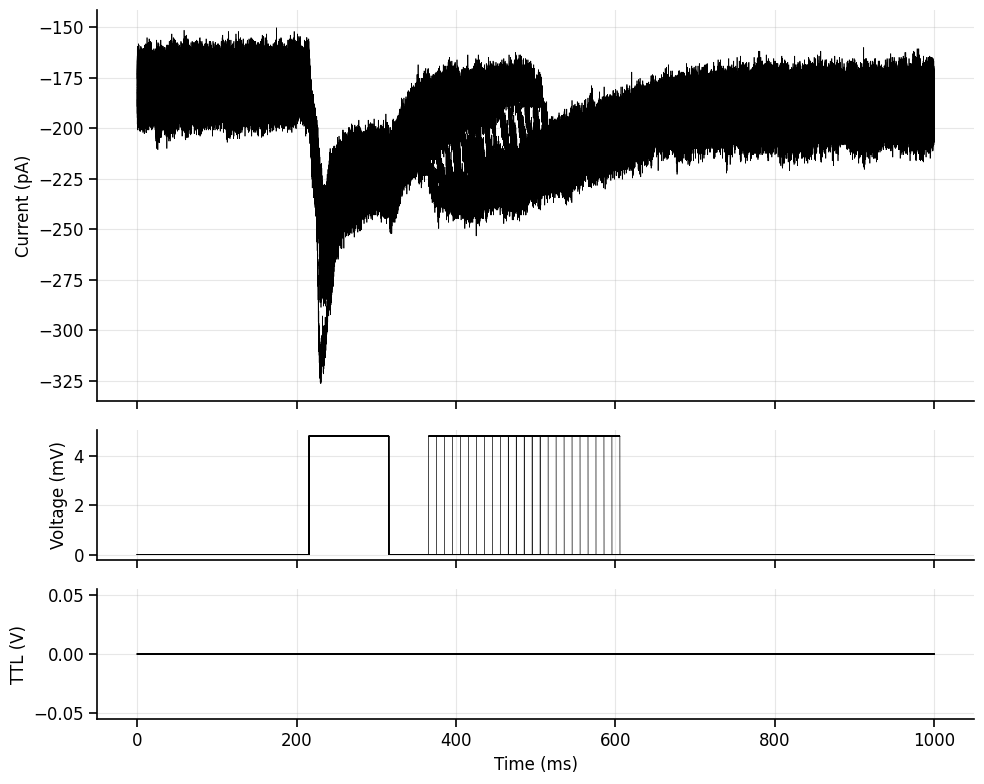

In [4]:
traces = Trace.from_axon_file(filename=data_file, 
                              load_voltage=True, 
                              load_ttl=True,
                              units=['pA', 'mV', 'V'], 
                              concatenate_sweeps=False)
print(traces)

time_units = 'ms' # specify seconds (s), or milliseconds (ms)

# ----------------------------------------------------------------------------------------------------------------
# %matplotlib widget
%matplotlib inline
traces.plot(plot_ttl=True, plot_voltage=True, sweep='all', time_units='ms')
plt.show()

## 2. Signal processing

### Baseline the trace and apply highpass / lowpass / bandpass filtering

We want to measure the current amplitude relative to the baseline before the stimulus starts.  

Depending on you recording, you may also have 50/60 Hz line noise, high-frequency noise, or slow drift in your recording that we can correct for.

You can run this next cell as many times as you want to fine-tune the filtering parameters:

BASELINE SUBTRACTED:
Baseline currents (pA): [-187.7844 -190.7939 -187.0217 ... -167.5411 -167.5007 -167.2439]


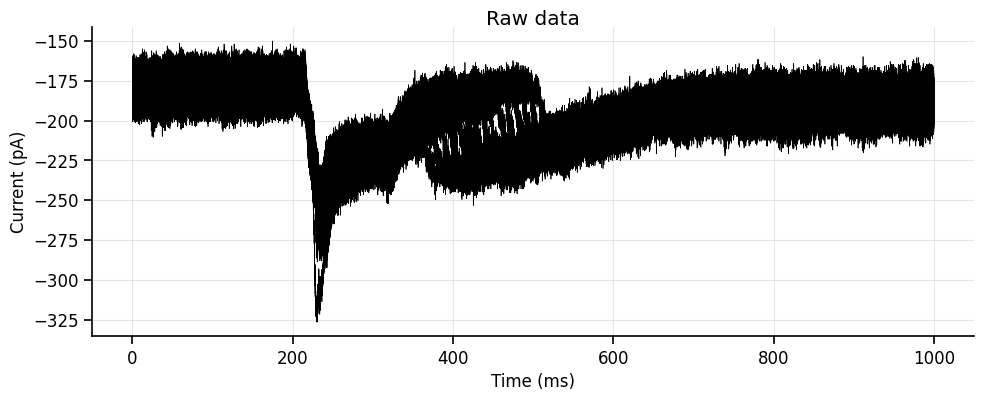

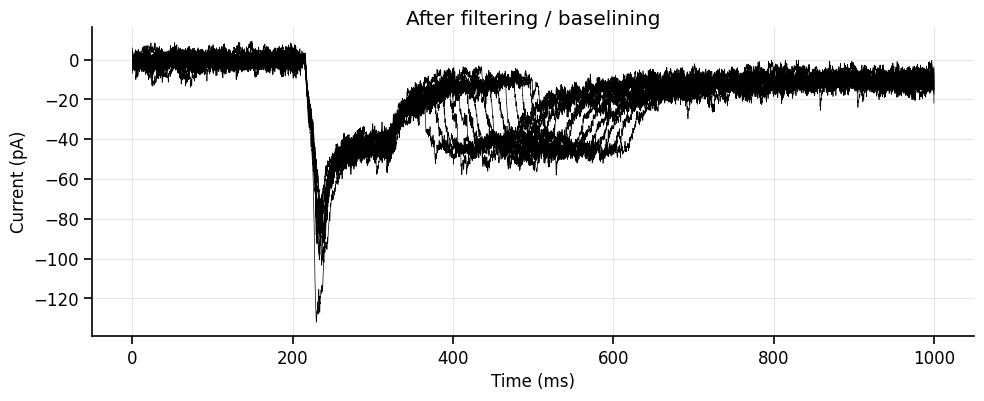

In [5]:
subtract_baseline = True    # Subtract baseline to measure the current relative to the baseline (just before the voltage step)

linear_detrending = False   # Detrend the data to remove linear or constant trends (e.g slow drift)
lowpass_filter    = True  # Lowpass filter (removes high-frequency noise)
bandpass_filter   = False   # Bandpass filter (removes 50/60 Hz mainline noise)


# ----------------------------------------------------------------------------------------------------------------
filtered_traces = traces.copy()
if linear_detrending:
    # Detrend the data to remove linear or constant trends (e.g slow drift)
    filtered_traces = filtered_traces.detrend(detrend_type='linear', num_segments=1, apply_to_voltage=False)

if lowpass_filter:
    # Lowpass filter (removes high-frequency noise)
    filtered_traces = filtered_traces.lowpass_filter(cutoff_freq = 2000) # Choose a value in units of Hz
    
if bandpass_filter:
    # Bandpass filter (removes 50/60 Hz mainline noise)
    filtered_traces = filtered_traces.filter_line_noise(
        line_freq = 60, # Frequency (Hz) of noise to remove: 50 Hz (in Europe) or 60 Hz (in the US).
        width = 1, # Width (Hz) controls the width of frequency bands around the line frequency the filter cuts out.
        method = 'notch') # Options: 'notch' (IIR notch filter), 'bandstop' (Butterworth), or 'fft' (spectral).

if subtract_baseline:
    opto_stim_start = traces.get_step_events(threshold=traces.voltage_data[0,0]+1, channel='voltage', edge='rising', polarity='positive', time_units=time_units, sweep=0)
    start_baseline = max(0, opto_stim_start[0]-5)  # Start time for baseline subtraction
    end_baseline = opto_stim_start[0]  # End time for baseline subtraction
    filtered_traces.subtract_baseline(start_time = start_baseline, end_time = end_baseline , time_units = time_units, channel = 'current')

# Plot the traces before and after filtering
if any([linear_detrending, lowpass_filter, bandpass_filter, subtract_baseline]):
    # %matplotlib widget
    %matplotlib inline
    ax = traces.plot(plot_voltage=False, time_units=time_units, sweep='all')
    ax.set_title('Raw data', y=0.98)
    plt.show()

    ax = filtered_traces.plot(plot_voltage=False, time_units=time_units, sweep='all')
    ax.set_title('After filtering / baselining', y=0.98)
    plt.show()


Once you are happy with the filter setting, run the next cell to implement them:

In [6]:
if any([linear_detrending, lowpass_filter, bandpass_filter, subtract_baseline]):
    print("Applied filtering and/or baseline subtraction to the traces.")
    traces = filtered_traces

Applied filtering and/or baseline subtraction to the traces.


## 3. Measure recovery currents

#### 3.1 Reference current

First let's get the times of all the voltage steps

In [7]:
step_times = traces.get_step_events(threshold=traces.voltage_data[0,0]+1, polarity='positive', sweep='all',
                                   edge='rising', channel='voltage', time_units=time_units)

step_end_times = traces.get_step_events(threshold=traces.voltage_data[0,0]+1, polarity='positive', sweep='all',
                                   edge='falling', channel='voltage', time_units=time_units)
print(f"Step times:")
step_times

Step times:


[array([215.62, 365.62]),
 array([215.62, 375.62]),
 array([215.62, 385.62]),
 array([215.62, 395.62]),
 array([215.62, 405.62]),
 array([215.62, 415.62]),
 array([215.62, 425.62]),
 array([215.62, 435.62]),
 array([215.62, 445.62]),
 array([215.62, 455.62]),
 array([215.62, 465.62]),
 array([215.62, 475.62]),
 array([215.62, 485.62]),
 array([215.62, 495.62]),
 array([215.62, 505.62])]

Now we can measure the current after the initial stim. This will be our reference current to compare against when estimating recovery.

We need to define a time window in which to measure the current peak

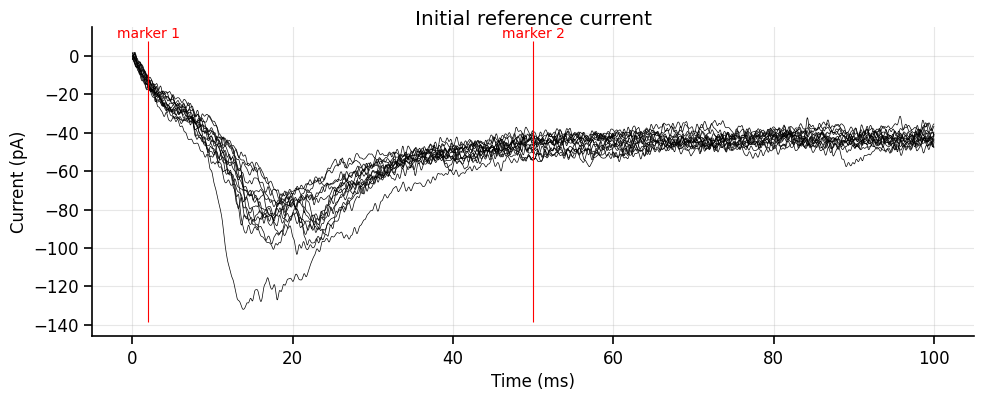

In [8]:
marker_1 = 2
marker_2 = 50

first_opto_stim_start = traces.get_step_events(threshold=traces.voltage_data[0,0]+1, channel='voltage', edge='rising', polarity='positive', time_units=time_units, sweep=0)
first_opto_stim_end = traces.get_step_events(threshold=traces.voltage_data[0,0]+1, channel='voltage', edge='falling', polarity='positive', time_units=time_units, sweep=0)
window_size = first_opto_stim_end[0] - first_opto_stim_start[0]
reference_step_traces = traces.crop(timepoint=step_times[0][0], window=window_size, time_units=time_units)
ax = reference_step_traces.plot(plot_voltage=False, plot_ttl=False, time_units=time_units, sweep='all', marker_1=marker_1, marker_2=marker_2)
ax.set_title('Initial reference current',y=0.98)
plt.show()

reference_currents, _ = traces.get_measurements(start_time=marker_1, end_time=marker_2, measurement_type='min', time_units=time_units)

#### 3.2. Recovery currents

We can now repeat this for the other (recovery) currents

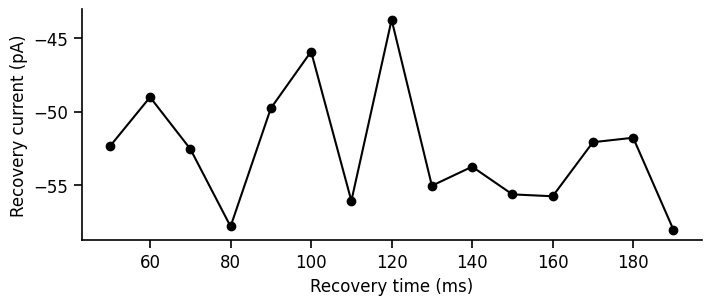

In [9]:
recovery_currents = []
recovery_time = []
for i, (step_time, step_end) in enumerate(zip(step_times, step_end_times)):
    current,_ = traces.get_measurements(sweep=i, measurement_type='min', time_units=time_units, start_time=step_time[1]+marker_1, end_time=step_time[1]+marker_2)
    recovery_currents.append(current)
    recovery_time.append(step_time[1]-step_end[0])
recovery_time = np.array(recovery_time)

%matplotlib inline
fig,ax = plt.subplots(figsize=(8,3))
ax.plot(recovery_time, recovery_currents, '-o', color='black')
ax.set_ylabel('Recovery current (pA)')
ax.set_xlabel("Recovery time (ms)")
plt.show()

Now let's plot the same thing, but normalized against the reference current

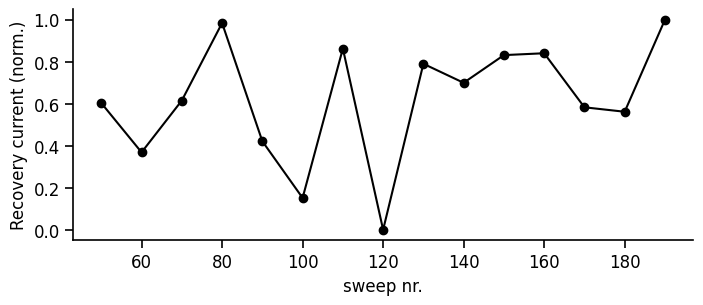

In [10]:
# Normalize the measured currents against the baseline/reference currents
peak_currents_norm = (recovery_currents - np.max(recovery_currents)) / (np.min(recovery_currents) - np.max(recovery_currents))

%matplotlib inline
fig,ax = plt.subplots(figsize=(8,3))
ax.plot(recovery_time, peak_currents_norm, '-o', color='black')
ax.set_ylabel('Recovery current (norm.)')
ax.set_xlabel("sweep nr.")
plt.show()

### 3.4. Plot the channel recovery curve

Here we will need to manually define the recovery time points based on our protocol.

Tau: 466555.23 ms


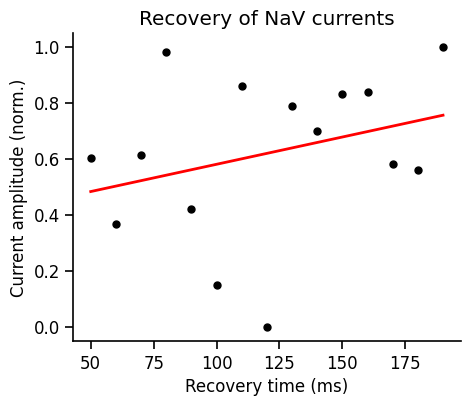

In [11]:
# Plot the normalized current steps against the holding voltages
%matplotlib inline
fig,ax = plt.subplots(figsize=(5, 4))
ax.plot(recovery_time, peak_currents_norm, 'o', color='black', markersize=5)
ax.set_xlabel('Recovery time (ms)')
ax.set_ylabel('Current amplitude (norm.)')
ax.set_title('Recovery of NaV currents')

# Fit exponential curve to the data to get the time constant
from scipy.optimize import curve_fit
def exponential_curve(time, V0, tau, V_inf):
    return V0 * np.exp(-time / tau) + V_inf
V0_guess = 0 
Vinf_guess = 1
tau_guess = 20 # ms
p0 = [V0_guess, tau_guess, Vinf_guess]
popt, _ = curve_fit(exponential_curve, recovery_time, peak_currents_norm, p0=p0)
V0_fit, tau_fit, Vinf_fit = popt

print(f"Tau: {tau_fit:.2f} ms")

# Overlay exponential fit
fit_trace = exponential_curve(recovery_time, *popt)
ax.plot(recovery_time, fit_trace, color='r', alpha=1, linewidth=2)
plt.show()